# Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
import gensim
import string

In [2]:
from nltk.corpus import stopwords  
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration

In [4]:
data = pd.read_csv('data.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Data Processing

In [5]:
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [6]:
data_count=data.iloc[:,2:].sum()

# Visualization

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


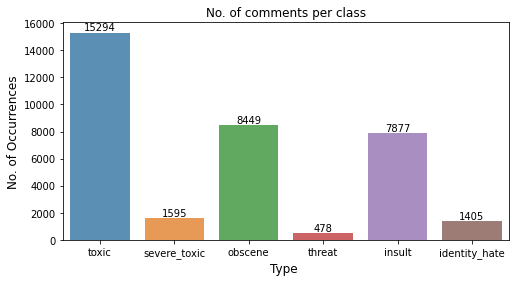

In [7]:
plt.figure(figsize=(8,4))

ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [8]:
num_rows = len(data)
print(num_rows)

159571


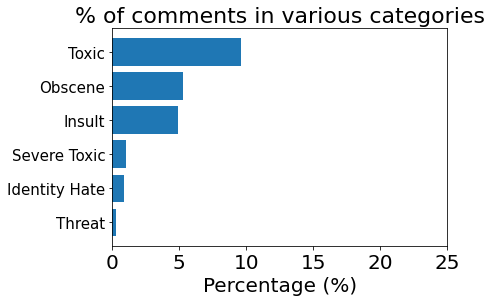

In [9]:
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100
ind = np.arange(6)
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

Text preprocessing

In [10]:
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [11]:
data_tox = data.loc[:,['id','comment_text','toxic']]
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [12]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]
data_thr = data.loc[:,['id','comment_text','threat']]

WordCloud

In [13]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [14]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

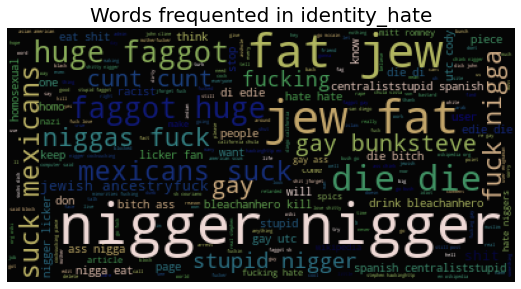

In [15]:
wordcloud(data_ide,'identity_hate')

In [16]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [17]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [18]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

In [19]:
data_sev[data_sev['severe_toxic'] == 1].count()

id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [20]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

In [21]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [22]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [23]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

In [24]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [25]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [26]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [27]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [28]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

In [29]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [30]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format


# Support Vector Machine

In [31]:
from sklearn.svm import SVC
SVM = SVC()
SVM.fit(X_train_fit, y_train)
predictions = SVM.predict(X_test_fit)
val1 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for SVM: ", val1, "\n")
print("*Confusion Matrix for SVM: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for SVM: ")
print(classification_report(y_test, predictions))

*Accuracy score for SVM:  86.46666666666667 

*Confusion Matrix for SVM: 
[[1344  119]
 [ 287 1250]]
*Classification Report for SVM: 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1463
           1       0.91      0.81      0.86      1537

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.86      3000
weighted avg       0.87      0.86      0.86      3000



# Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train_fit, y_train)
predictions = RF.predict(X_test_fit)
val2 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for RF: ", val2, "\n")
print("*Confusion Matrix for RF: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for RF: ")
print(classification_report(y_test, predictions))

*Accuracy score for RF:  84.56666666666666 

*Confusion Matrix for RF: 
[[1339  124]
 [ 339 1198]]
*Classification Report for RF: 
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1463
           1       0.91      0.78      0.84      1537

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



# Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train_fit, y_train)
predictions = DT.predict(X_test_fit)
val3 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for DT: ", val3, "\n")
print("*Confusion Matrix for DT: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for DT: ")
print(classification_report(y_test, predictions))

*Accuracy score for DT:  81.39999999999999 

*Confusion Matrix for DT: 
[[1238  225]
 [ 333 1204]]
*Classification Report for DT: 
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1463
           1       0.84      0.78      0.81      1537

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000



# KNeighborsClassifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train_fit, y_train)
predictions = KNN.predict(X_test_fit)
val4 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for KNN: ", val4, "\n")
print("*Confusion Matrix for KNN: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for KNN: ")
print(classification_report(y_test, predictions))

*Accuracy score for KNN:  53.900000000000006 

*Confusion Matrix for KNN: 
[[1453   10]
 [1373  164]]
*Classification Report for KNN: 
              precision    recall  f1-score   support

           0       0.51      0.99      0.68      1463
           1       0.94      0.11      0.19      1537

    accuracy                           0.54      3000
   macro avg       0.73      0.55      0.43      3000
weighted avg       0.73      0.54      0.43      3000



# LogisticRegression

In [38]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train_fit, y_train)
predictions = LR.predict(X_test_fit)
val5 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for LR: ", val5, "\n")
print("*Confusion Matrix for LR: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for LR: ")
print(classification_report(y_test, predictions))

*Accuracy score for LR:  86.43333333333332 

*Confusion Matrix for LR: 
[[1330  133]
 [ 274 1263]]
*Classification Report for LR: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1463
           1       0.90      0.82      0.86      1537

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.86      3000
weighted avg       0.87      0.86      0.86      3000



# Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train_fit.todense(), y_train)
predictions = GNB.predict(X_test_fit.todense())
val6 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for GNB: ", val6, "\n")
print("*Confusion Matrix for GNB: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for GNB: ")
print(classification_report(y_test, predictions))

*Accuracy score for GNB:  69.33333333333334 

*Confusion Matrix for GNB: 
[[ 876  587]
 [ 333 1204]]
*Classification Report for GNB: 
              precision    recall  f1-score   support

           0       0.72      0.60      0.66      1463
           1       0.67      0.78      0.72      1537

    accuracy                           0.69      3000
   macro avg       0.70      0.69      0.69      3000
weighted avg       0.70      0.69      0.69      3000



# Voting Classifier

In [39]:
from sklearn.ensemble import VotingClassifier 
from sklearn.tree import DecisionTreeClassifier 
estimator = [] 
estimator.append(('LR',  
                  LogisticRegression(solver ='lbfgs',  
                                     multi_class ='multinomial',  
                                     max_iter = 200))) 
estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier())) 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train_fit, y_train)
predictions = vot_hard.predict(X_test_fit)
val7 = (accuracy_score(y_test, predictions)*100)
print("*Accuracy score for Voting Classifier: ", val7, "\n")
print("*Confusion Matrix for Voting Classifier: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for Voting Classifier: ")
print(classification_report(y_test, predictions))

*Accuracy score for Voting Classifier:  83.8 

*Confusion Matrix for Voting Classifier: 
[[1388   75]
 [ 411 1126]]
*Classification Report for Voting Classifier: 
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1463
           1       0.94      0.73      0.82      1537

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.86      0.84      0.84      3000



# Model Comparsion

In [45]:
score = [val1,val2,val3,val4,val5,val6,val7]
#make variabel for save the result and to show it
classifier = ('Suport Vector Machine','Random Forest','Decision Tree','KNNeighbors','Logistic Regression','Naive Bayes Classifier','Voting Classifier')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[0 1 2 3 4 5 6]
[86.46666666666667, 84.56666666666666, 81.39999999999999, 53.900000000000006, 86.43333333333332, 69.33333333333334, 83.8]


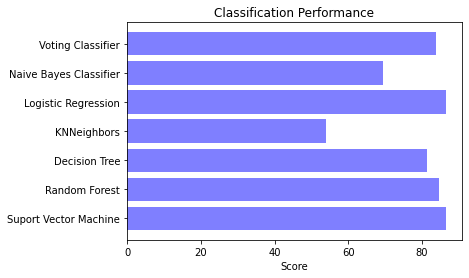

In [46]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()

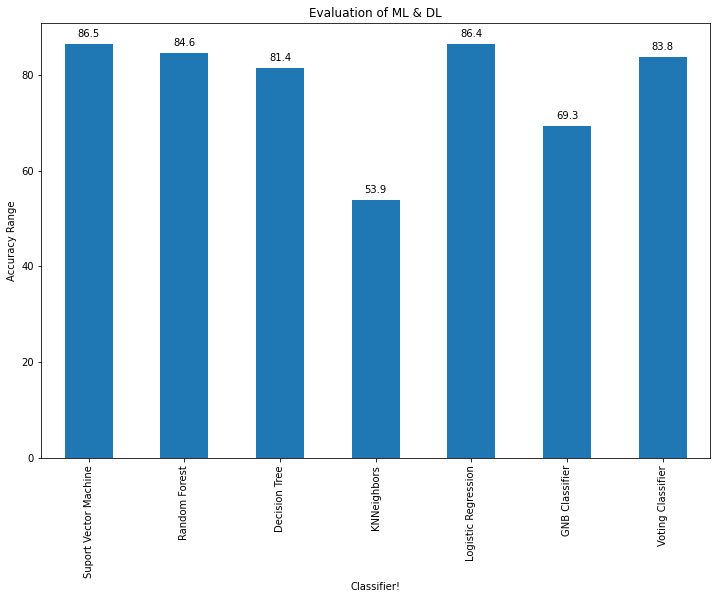

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
frequencies = [val1,val2,val3,val4,val5,val6,val7]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = ['Suport Vector Machine','Random Forest','Decision Tree','KNNeighbors','Logistic Regression','GNB Classifier','Voting Classifier']

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & DL')
ax.set_xlabel('Classifier!')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()
#plt.savefig("image.png")